# LSTM emotion recognizer

Note: This notebook is designed to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer and the emotion dataset.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Import modules and set random seeds.

In [2]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [3]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size
print(f'Vocabulary size: {VOCAB_SIZE}')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Vocabulary size: 30522


Download the emotion dataset and check the maximum text length.

In [4]:
from datasets import load_dataset
emotions = load_dataset('emotion', trust_remote_code=True)
max_textlen = max(
    [len(text.split(' '))
     for text in emotions['train']['text'] + emotions['validation']['text']])
print(f'Maximum text length: {max_textlen}')

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Maximum text length: 66


Create the training and test datasets.

In [5]:
MAX_LEN = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=MAX_LEN,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_label = tf.keras.utils.to_categorical(emotions['train']['label'], 6)

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=MAX_LEN,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_label = tf.keras.utils.to_categorical(emotions['validation']['label'], 6)

emotion_labels = emotions['train'].features['label'].names
emotion_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Show the first training data.

In [6]:
train_text[0]

array([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

Convert the first training data back to the original text.

In [7]:
' '.join(tokenizer.convert_ids_to_tokens(train_text[0]))

'[CLS] i didn ##t feel humiliated [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

Define the bidirectional LSTM model.

In [8]:
lstm_model = models.Sequential(name='Bidirectional_LSTM_classifier')
lstm_model.add(layers.Input(shape=(None,), name='input_ids'))
lstm_model.add(layers.Embedding(VOCAB_SIZE, 512, name='text_embedding'))
lstm_model.add(layers.Bidirectional(layers.LSTM(512, return_sequences=True),
                                    name='bidirectional_LSTM1'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout1'))
lstm_model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=False),
                                    name='bidirectional_LSTM2'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout2'))
lstm_model.add(layers.Dense(256, activation='relu', name='feedforward'))
lstm_model.add(layers.Dropout(rate=0.4, name='dropout3'))
lstm_model.add(layers.Dense(6, activation='softmax', name='softmax'))

lstm_model.summary()

Model: "Bidirectional_LSTM_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_embedding (Embedding)           │ (None, None, 512)           │      15,627,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_LSTM1 (Bidirectional)  │ (None, None, 1024)          │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_LSTM2 (Bidirectional)  │ (None, 512)                 │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward (Dense)                  │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout3 (Dropout)                   │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,582,022 (86.14 MB)

 Trainable params: 22,582,022 (86.14 MB)

 Non-trainable params: 0 (0.00 B)

Compile the model using the Adam optimizer, and the categorical crossentroy as a loss function.

In [9]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['acc'])

Train the model. It achieves around 90% accuracy.

In [10]:
%%time
history = lstm_model.fit(train_text, train_label,
                         validation_data=(test_text, test_label),
                         batch_size=16, epochs=8)

Epoch 1/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 74s 67ms/step - acc: 0.3504 - loss: 1.5646 - val_acc: 0.6995 - val_loss: 0.8354
Epoch 2/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - acc: 0.7399 - loss: 0.7125 - val_acc: 0.8400 - val_loss: 0.4543
Epoch 3/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 75ms/step - acc: 0.8911 - loss: 0.3155 - val_acc: 0.8910 - val_loss: 0.3467
Epoch 4/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 79s 72ms/step - acc: 0.9424 - loss: 0.1714 - val_acc: 0.8940 - val_loss: 0.3274
Epoch 5/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - acc: 0.9644 - loss: 0.1160 - val_acc: 0.8935 - val_loss: 0.3689
Epoch 6/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - acc: 0.9658 - loss: 0.1027 - val_acc: 0.9010 - val_loss: 0.3569
Epoch 7/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 71ms/step - acc: 0.9743 - loss: 0.0782 - val_acc: 0.9035 - val_loss: 0.3896
Epoch 8/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 79s 68ms/step - acc: 0.9779 - loss: 0.0672 - val_acc: 0.9030 - val_loss: 0.3885
CPU times: user 8min 16s, sys: 3

Plot charts for the accuracy and loss values.

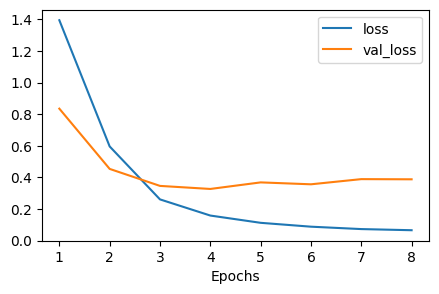

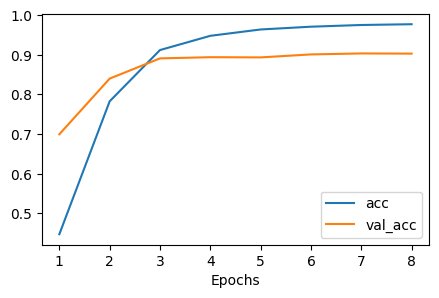

In [11]:
df = DataFrame({'loss': history.history['loss'],
               'val_loss': history.history['val_loss']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'acc': history.history['acc'],
               'val_acc': history.history['val_acc']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(5, 3))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

Show the confusion matrix against the test set.

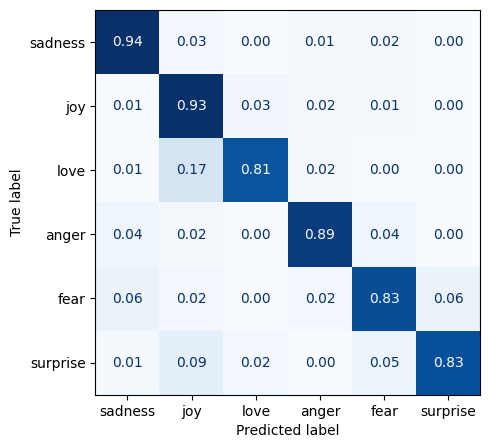

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = lstm_model.predict(test_text, verbose=0)

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

Show predictions for some sample texts.

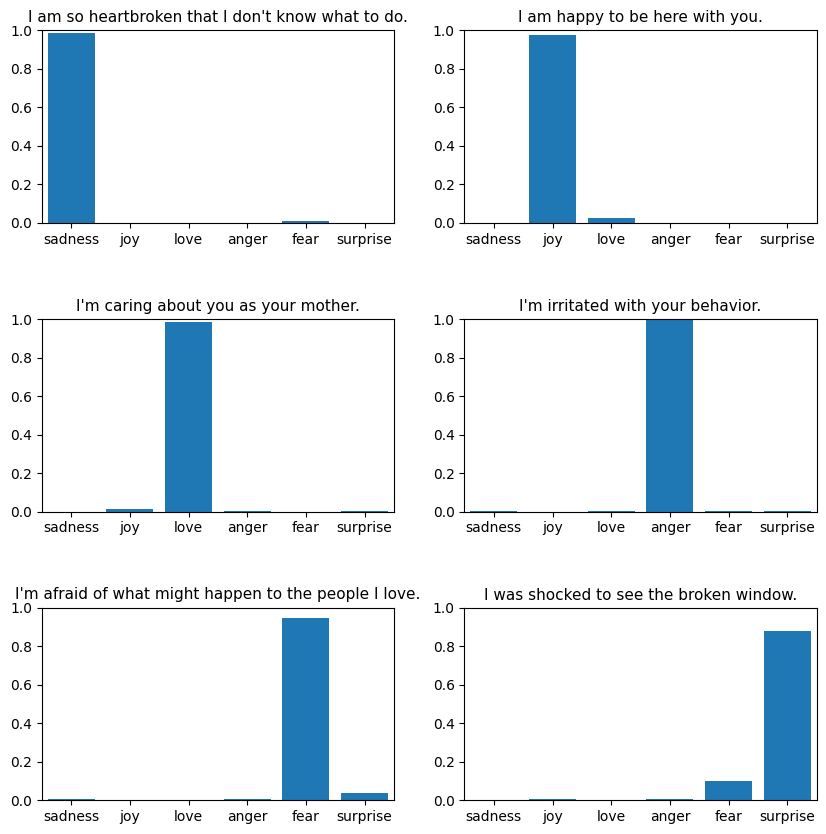

In [26]:
input_text = [
    "I am so heartbroken that I don't know what to do.",
    "I am happy to be here with you.",
    "I'm caring about you as your mother.",
    "I'm irritated with your behavior.",
    "I'm afraid of what might happen to the people I love.",
    "I was shocked to see the broken window."]

tokenized_text = tokenizer(input_text, max_length=MAX_LEN,
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])

predictions = lstm_model.predict(input_ids, verbose=0)

n = len(predictions)
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5)

for c, pred in enumerate(predictions):
    subplot = fig.add_subplot(3, 2, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c], fontsize=11)
    _ = subplot.bar(range(6), pred, align='center')